In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
from tqdm import tqdm
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.math import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
train_dir = f'/kaggle/input/asl_alphabet_train/asl_alphabet_train'

In [3]:
print(os.listdir('/kaggle/input'))


['asl_alphabet_test', 'asl_alphabet_train']


In [4]:
image_paths = []
labels = []
for label in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, label)
    
    # Ensure it's a directory
    if os.path.isdir(folder_path):
        # Loop through each image in the folder
        for img_name in os.listdir(folder_path):
            # Full path to the image
            img_path = os.path.join(folder_path, img_name)
            
            # Append the image path and label to their respective lists
            image_paths.append(img_path)
            labels.append(label)

In [5]:
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

In [6]:
df.head()

,image_path,label
0,/kaggle/input/asl_alphabet_train/asl_alphabet_...,N
1,/kaggle/input/asl_alphabet_train/asl_alphabet_...,N
2,/kaggle/input/asl_alphabet_train/asl_alphabet_...,N
3,/kaggle/input/asl_alphabet_train/asl_alphabet_...,N
4,/kaggle/input/asl_alphabet_train/asl_alphabet_...,N


In [23]:

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

train_df.to_csv('train.csv',index=False)
val_df.to_csv('val.csv',index=False)

In [8]:
# Show the first few rows of the training DataFrame
print("Training DataFrame:")
print(train_df.head())

# Show the first few rows of the validation DataFrame
print("\nValidation DataFrame:")
print(val_df.head())

Training DataFrame:
                                              image_path  label
34706  /kaggle/input/asl_alphabet_train/asl_alphabet_...      X
57691  /kaggle/input/asl_alphabet_train/asl_alphabet_...      T
6065   /kaggle/input/asl_alphabet_train/asl_alphabet_...  space
42250  /kaggle/input/asl_alphabet_train/asl_alphabet_...      Y
32487  /kaggle/input/asl_alphabet_train/asl_alphabet_...      M

Validation DataFrame:
                                              image_path label
55447  /kaggle/input/asl_alphabet_train/asl_alphabet_...     O
16935  /kaggle/input/asl_alphabet_train/asl_alphabet_...   del
57819  /kaggle/input/asl_alphabet_train/asl_alphabet_...     T
61640  /kaggle/input/asl_alphabet_train/asl_alphabet_...     V
4418   /kaggle/input/asl_alphabet_train/asl_alphabet_...     R


In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')  # 29 classes for A-Z, SPACE, DELETE, NOTHING
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,973 (1.63 MB)

 Trainable params: 426,013 (1.63 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Rescale pixel values

)

val_datagen = ImageDataGenerator(rescale=1./255)


In [11]:
image_size = (200, 200) 
batch_size = 32

# Create the training generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',       # Column containing image paths
    y_col='label',            # Column containing labels
    target_size=image_size,   
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

# Create the validation generator
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False            
)


Found 78300 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [12]:
 history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,batch_size=500 )

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724581726.559131     104 service.cc:145] XLA service 0x7d54a4003710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724581726.559187     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724581726.559192     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   2/2447 ━━━━━━━━━━━━━━━━━━━━ 2:34 63ms/step - accuracy: 0.0703 - loss: 3.8993  

I0000 00:00:1724581734.634458     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 358s 141ms/step - accuracy: 0.5480 - loss: 1.5046 - val_accuracy: 0.9668 - val_loss: 0.0983
Epoch 2/10
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 138s 56ms/step - accuracy: 0.9806 - loss: 0.0663 - val_accuracy: 0.9711 - val_loss: 0.0926
Epoch 3/10
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 154s 63ms/step - accuracy: 0.9910 - loss: 0.0309 - val_accuracy: 0.7397 - val_loss: 0.9174
Epoch 4/10
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 140s 57ms/step - accuracy: 0.9918 - loss: 0.0270 - val_accuracy: 0.7100 - val_loss: 1.2398
Epoch 5/10
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 144s 59ms/step - accuracy: 0.9933 - loss: 0.0217 - val_accuracy: 0.9902 - val_loss: 0.0296
Epoch 6/10
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 149s 61ms/step - accuracy: 0.9941 - loss: 0.0185 - val_accuracy: 0.9991 - val_loss: 0.0022
Epoch 7/10
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 142s 58ms/step - accuracy: 0.9964 - loss: 0.0128 - val_accuracy: 0.9715 - val_loss: 0.0933
Epoch 8/10
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 150s 61ms/step - accuracy: 0.9953 - l

In [13]:
model.save("English_sigh_language.h5")

In [14]:
test_dir = r'/kaggle/input/asl_alphabet_test/asl_alphabet_test'

In [15]:
print(os.listdir(test_dir))

['A_test.jpg', 'E_test.jpg', 'L_test.jpg', 'N_test.jpg', 'S_test.jpg', 'D_test.jpg', 'G_test.jpg', 'I_test.jpg', 'W_test.jpg', 'M_test.jpg', 'nothing_test.jpg', 'X_test.jpg', 'H_test.jpg', 'Q_test.jpg', 'C_test.jpg', 'T_test.jpg', 'P_test.jpg', 'V_test.jpg', 'Y_test.jpg', 'U_test.jpg', 'space_test.jpg', 'O_test.jpg', 'B_test.jpg', 'R_test.jpg', 'F_test.jpg', 'Z_test.jpg', 'J_test.jpg', 'K_test.jpg']


In [22]:
file_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.jpg')]

labels = [os.path.splitext(os.path.basename(fname))[0] for fname in file_paths]

test_df = pd.DataFrame({
    'filename': file_paths,
    'label': labels
})

classes = sorted(set(os.path.splitext(fname)[0] for fname in os.listdir(test_dir) if fname.endswith('.jpg')))
class_indices = {cls: idx for idx, cls in enumerate(classes)}

test_df['class_index'] = test_df['label'].map(class_indices)


print(test_df.head())
test_df.to_csv('test.csv',index=False)


                                            filename   label  class_index
0  /kaggle/input/asl_alphabet_test/asl_alphabet_t...  A_test            0
1  /kaggle/input/asl_alphabet_test/asl_alphabet_t...  E_test            4
2  /kaggle/input/asl_alphabet_test/asl_alphabet_t...  L_test           11
3  /kaggle/input/asl_alphabet_test/asl_alphabet_t...  N_test           13
4  /kaggle/input/asl_alphabet_test/asl_alphabet_t...  S_test           18


In [17]:
test_df.head()

,filename,label,class_index
0,/kaggle/input/asl_alphabet_test/asl_alphabet_t...,A_test,0
1,/kaggle/input/asl_alphabet_test/asl_alphabet_t...,E_test,4
2,/kaggle/input/asl_alphabet_test/asl_alphabet_t...,L_test,11
3,/kaggle/input/asl_alphabet_test/asl_alphabet_t...,N_test,13
4,/kaggle/input/asl_alphabet_test/asl_alphabet_t...,S_test,18


In [18]:
test_datagen = ImageDataGenerator(
    rescale=1./255, 
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',      # Column with image file paths
    y_col='label',         # Column with image labels
    target_size=(200, 200), 
    batch_size=32,         
    class_mode='categorical',  
    shuffle=False          
)

Found 28 validated image filenames belonging to 28 classes.


In [36]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
imgs_dir = test_dir
imgs = os.listdir(imgs_dir)
print(imgs)
class_mapping = train_gen.class_indices
print(class_mapping)

['A_test.jpg', 'E_test.jpg', 'L_test.jpg', 'N_test.jpg', 'S_test.jpg', 'D_test.jpg', 'G_test.jpg', 'I_test.jpg', 'W_test.jpg', 'M_test.jpg', 'nothing_test.jpg', 'X_test.jpg', 'H_test.jpg', 'Q_test.jpg', 'C_test.jpg', 'T_test.jpg', 'P_test.jpg', 'V_test.jpg', 'Y_test.jpg', 'U_test.jpg', 'space_test.jpg', 'O_test.jpg', 'B_test.jpg', 'R_test.jpg', 'F_test.jpg', 'Z_test.jpg', 'J_test.jpg', 'K_test.jpg']
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [43]:

def get_class_label(predictions, class_mapping):
    labels_mapping = {v: k for k, v in class_mapping.items()}
    predicted_labels = [labels_mapping[pred] for pred in predictions]
    return predicted_labels

def predict_image_class(model, img_path):
    # Load the image using TensorFlow
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(200, 200))  # Resize to match model's input size
    
    # Convert the image to an array and expand dimensions to match the model input
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Normalize the image array (if required by your model)
    img_array /= 255.0  # Adjust based on your model's requirements
    
    # Predict the class
    predictions = model.predict(img_array, verbose=0)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)
    
    return predicted_class[0]  # Return the predicted class index

def extract_label_from_filename(filename):
    # Extract the label from filename, assuming label is the part before the first underscore
    return filename.split('_')[0]

def calculate_accuracy(predictions, true_labels):
    correct_predictions = sum(p == t for p, t in zip(predictions, true_labels))
    accuracy = correct_predictions / len(true_labels) * 100
    return accuracy


imgs = [f for f in os.listdir(imgs_dir) if os.path.isfile(os.path.join(imgs_dir, f))]

predictions = []
true_labels = []

for img_filename in imgs:
    img_path = os.path.join(imgs_dir, img_filename)  # Construct the full path to the image
    
    # Predict the class
    predicted_index = predict_image_class(model, img_path)
    predictions.append(predicted_index)
    
    # Extract true label from the filename
    true_label = extract_label_from_filename(img_filename)
    true_label_index = class_mapping.get(true_label, -1)  # Map label to index or -1 if not found
    true_labels.append(true_label_index)
    
    print(f'Predicted Index for {img_filename} -----> {predicted_index}, True Label Index -----> {true_label_index}')

# Calculate and print the accuracy
accuracy = calculate_accuracy(predictions, true_labels)
print(f'Accuracy: {accuracy:.2f}%')

Predicted Index for A_test.jpg -----> 0, True Label Index -----> 0
Predicted Index for E_test.jpg -----> 4, True Label Index -----> 4
Predicted Index for L_test.jpg -----> 11, True Label Index -----> 11
Predicted Index for N_test.jpg -----> 13, True Label Index -----> 13
Predicted Index for S_test.jpg -----> 18, True Label Index -----> 18
Predicted Index for D_test.jpg -----> 3, True Label Index -----> 3
Predicted Index for G_test.jpg -----> 6, True Label Index -----> 6
Predicted Index for I_test.jpg -----> 8, True Label Index -----> 8
Predicted Index for W_test.jpg -----> 22, True Label Index -----> 22
Predicted Index for M_test.jpg -----> 12, True Label Index -----> 12
Predicted Index for nothing_test.jpg -----> 27, True Label Index -----> 27
Predicted Index for X_test.jpg -----> 23, True Label Index -----> 23
Predicted Index for H_test.jpg -----> 7, True Label Index -----> 7
Predicted Index for Q_test.jpg -----> 16, True Label Index -----> 16
Predicted Index for C_test.jpg -----> 2,

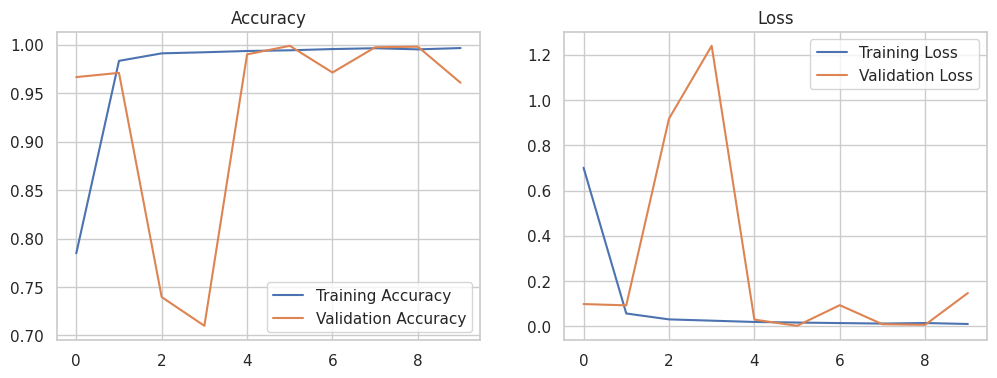

In [42]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


